In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd /content/drive/My Drive/C13550/Lesson5/

/content/drive/My Drive/C13550/Lesson5


In [0]:
import re, os, cv2
import numpy as np
# ----------------------------------------------------------------------------
def list_files(directory, ext=None):
    return [os.path.join(directory, f) for f in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, f)) and ( ext==None or re.match('([\w_-]+\.(?:' + ext + '))', f) )]

# ----------------------------------------------------------------------------
def load_images(path,label):
    X = []
    Y = []
    label = str(label)
    for fname in list_files( path, ext='jpg' ): 
        img = cv2.imread(fname)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        Y.append(label)
        
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

In [33]:
X, y = load_images('Dataset/money/20',0)
X_aux, y_aux = load_images('Dataset/money/5',1)
X = np.concatenate((X, X_aux), axis=0)
y = np.concatenate((y, y_aux), axis=0)
print(X.shape)
print(y.shape)


(60, 224, 224, 3)
(60,)


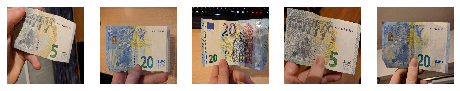

In [34]:
import random 
random.seed(42) 
from matplotlib import pyplot as plt

for idx in range(5): 
  rnd_index = random.randint(0, 60) 
  plt.subplot(1,5,idx+1),plt.imshow(cv2.cvtColor(X[rnd_index],cv2.COLOR_BGR2RGB)) 
  plt.xticks([]),plt.yticks([])
plt.savefig("money_samples.jpg", bbox_inches='tight')
plt.show() 

In [35]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
 
input_tensor = Input(shape=(224, 224, 3))
 
base_model = MobileNet(input_tensor=input_tensor,weights='imagenet',include_top=False)
 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
 
model = Model(base_model.input, x)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [0]:
for layer in model.layers:
    layer.trainable=False
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
import keras
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])


In [0]:
from keras import utils as np_utils
X = preprocess_input(X)
#X = (X.astype(np.float32))/255.0 
y = np_utils.to_categorical(y)



In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(48, 224, 224, 3)
(48, 2)
(12, 224, 224, 3)
(12, 2)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(  
      rotation_range=90,     
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      horizontal_flip=True,    
      vertical_flip=True,
      zoom_range=0.4)
train_datagen.fit(x_train)


In [0]:
from keras.callbacks import ModelCheckpoint
ckpt = ModelCheckpoint('model_money.h5', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=False)



In [42]:
model.fit_generator(train_datagen.flow(x_train, y_train,
                                 batch_size=4),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[ckpt],
                    steps_per_epoch=len(x_train) // 4,
                    workers=4)

Epoch 1/50
12/12 [==============================] - 130s 11s/step - loss: 1.3929 - acc: 0.7083 - val_loss: 1.6406 - val_acc: 0.5000
Epoch 2/50
12/12 [==============================] - 85s 7s/step - loss: 2.2552 - acc: 0.5833 - val_loss: 0.3395 - val_acc: 0.8333
Epoch 3/50
12/12 [==============================] - 84s 7s/step - loss: 0.7994 - acc: 0.8542 - val_loss: 2.0744 - val_acc: 0.6667
Epoch 4/50
12/12 [==============================] - 81s 7s/step - loss: 1.4893 - acc: 0.6667 - val_loss: 0.1700 - val_acc: 0.9167
Epoch 5/50
12/12 [==============================] - 85s 7s/step - loss: 0.5958 - acc: 0.8333 - val_loss: 0.0454 - val_acc: 1.0000
Epoch 6/50
12/12 [==============================] - 85s 7s/step - loss: 2.5036 - acc: 0.6458 - val_loss: 0.2561 - val_acc: 0.8333
Epoch 7/50
12/12 [==============================] - 84s 7s/step - loss: 0.8460 - acc: 0.7917 - val_loss: 0.1056 - val_acc: 0.9167
Epoch 8/50
12/12 [==============================] - 84s 7s/step - loss: 0.8461 - acc: 0.

In [44]:
from sklearn import metrics
# Make a prediction
print ("Making predictions...")
#y_pred = model.predict(x_test)
y_pred = model.predict(x_test, batch_size=4, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
y_test_aux = y_test.copy()
y_test_pred = list()
for i in y_test_aux:
    y_test_pred.append(np.argmax(i))

print (y_pred)

# Evaluate the prediction
accuracy = metrics.accuracy_score(y_test_pred, y_pred)
precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test_pred, y_pred, average=None)
print('\nFinal results...')
print(metrics.classification_report(y_test_pred, y_pred))
print('Acc      : %.4f' % accuracy)
print('Precision: %.4f' % np.average(precision))
print('Recall   : %.4f' % np.average(recall))
print('F1       : %.4f' % np.average(f1))
print('Support  :', np.sum(support))

Making predictions...
[1 0 1 0 0 0 1 0 0 0 1 1]

Final results...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Acc      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
Support  : 12


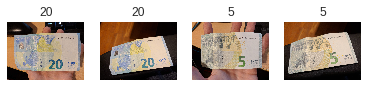

In [47]:
images = ['20.jpg','20_1.jpg','5.jpg','5_1.jpg']
model.load_weights('model_money.h5')

for number in range(len(images)):
  imgLoaded = cv2.imread('Dataset/testing/%s'%(images[number])) 
  img = cv2.resize(imgLoaded, (224, 224)) 
  #cv2.imwrite('test.jpg',img) 
  img = (img.astype(np.float32))/255.0 
  img = img.reshape(1, 224, 224, 3) 
  plt.subplot(1,5,number+1),plt.imshow(cv2.cvtColor(imgLoaded,cv2.COLOR_BGR2RGB)) 
  plt.title('20' if np.argmax(model.predict(img)[0]) == 0 else '5') 
  plt.xticks([]),plt.yticks([]) 

plt.show()
